# Contents and why we need this lab

This lab is about implementing neural networks yourself before we start using other frameworks which hide some of the computation from you. It builds on the first lab where you derived the equations for neural network forward and backward propagation and gradient descent parameter updates. 

All the frameworks for deep learning you will meet from now on uses automatic differentiation (autodiff) so you don't have to code the backward step yourself. In this version of this lab you will develop your own autodif implementation. We also have a [version](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/2_Feedforward_NumPy/2.1-FNN-NumPy.ipynb) of this lab where you have to code the backward pass explicitly in Numpy.

# External sources of information

1. Jupyter notebook. You can find more information about Jupyter notebooks [here](https://jupyter.org/). It will come as part of the [Anaconda](https://www.anaconda.com/) Python installation. 
2. [NumPy](https://numpy.org/). Part of Anaconda distribution. If you already know how to program most things about Python and NumPy can be found through Google search.
3. [Nanograd](https://github.com/rasmusbergpalm/nanograd) is a minimalistic version of autodiff developed by Rasmus Berg Palm that we use for our framework.


# This notebook will follow the next steps:

1. Nanograd automatic differentiation framework
2. Finite difference method
3. Data generation
4. Defining and initializing the network
5. Forward pass
6. Training loop 
7. Testing your model
8. Further extensions

# Nanograd automatic differention framework

The [Nanograd](https://github.com/rasmusbergpalm/nanograd) framework defines a class Var which both holds a value and gradient value that we can use to store the intermediate values when we apply the chain rule of differentiation.

In [1]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/main/nanograd.py

from math import exp, log, tanh

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])
    
    def identity(self):
        return self
    
    def tanh(self):
        return Var(tanh(self.v), lambda: [(self, 1-tanh(self.v)**2)])
    
    def sigmoid(self):
        return Var(1.0/(1.0+exp(-self.v)), lambda: [(self, sigmoid(self.v)*(1-sigmoid(self.v)))])
    
    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])

    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

A few examples illustrate how we can use this:

In [2]:
a = Var(3.0)
b = Var(5.0)
f = a * b

f.backward()

for v in [a, b, f]:
    print(v)

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)


In [3]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise a) What is being calculated?

Explain briefly the output of the code? What is the expression we differentiate and with respect to what variables?

### Answer:

> To take the simple example: First, we define two variables $a = 3.0$ and $b = 5.0$. These two variables are then multiplied, which gives $f$ the value $15$. Then we backward propagate from $f$. Here we differentiate with regard to $a$, which gives $a$ the gradient of $5.0$ ($b$'s value). Then we differentiate with regard to $b$, which gives $b$ the gradient of $3.0$ ($a$'s value).
$$
\begin{align}
\frac{\partial}{\partial a} f = b = 5.0 \\
\frac{\partial}{\partial b} f = a = 3.0 \\
\frac{\partial}{\partial f} f = 1
\end{align}
$$

> For the second output, the same happens. Though, whenever we add two variables, their gradient is going to be one. E.g. the gradient for $c$ is $1$, as the derivative of $f$ with regard to $c$ is one.

## Exercise b) How does the backward function work?

For the first example above, make a schematic of the data structure which is generated when we define the expression for f. Then execture the backward function by hand to convince yourself that it indeed calculates the gradients with respect to the variables. Write down the sequence of calls to backprop for the first example above.

## Exercise c) What happens if we run backward again?

Try to execute the code below. Explain what happens.

In [4]:
f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=28.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


### Answer:

> The backpropagation is done one more time for the second example above. Here, we see that the gradients add on top of each other. This is not the desired behaviour, as we want to reset the gradients everytime, which we have to actively do ourselves.

## Exercise d) Zero gradient

We can zero the gradient by backpropagating a -1.0 as is shown in the example below. (If you have run backward multiple time then you also have to run the cell below an equal amount of times.) Explain what is going on.

In [5]:
a = Var(2.0)

for v in [a, b, c, d, e, f]:
    print(v)

f.backprop(-1.0)

print()
for v in [a, b, c, d, e, f]:
    print(v)

Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)

Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


### Answer:

> We see, that when we backpropagate with $-1.0$, we subtract the gradients from the variables, instead of adding them. Doing so several times will keep on subtracting the gradient. 

## Exercise e) Test correctness of derivatives with the finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to numerically test that backpropation implementation is working. In short we will use
$$
\frac{\partial f(a)}{\partial a} \approx \frac{f(a+da)-f(a)}{da}
$$
for $da \ll 1$.


_Insert your code in the cell below._


In [6]:
# test function - try to change into other functions as well
def test_function(a):
    a = Var(a)
    b = Var(5.0)
    f = a * b
    f.backward()
    return a,b,f

for v in test_function(3.0):
    print(v)

# Insert your finite difference code here
def finite_difference(da=1e-10):
    """
    This function compute the finite difference between
    
    Input:
    da:          The finite difference                           (float)
    
    Output:
    finite_difference: numerical approximation to the derivative (float) 
    """
    
    fa_da = test_function(3.0+da)[2].v
    fa = test_function(3.0)[2].v

    finite_difference = (fa_da - fa) / da
    
    return finite_difference

print(finite_difference())

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
5.000000413701855


> We see that the gradient for $a$, is approximately the same, using the finite difference method.

# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator supports various noise levels and it creates train, validation and test sets. You can modify it yourself if you want more or less challenging tasks.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [8]:
def data_generator(noise=0.1, n_samples=300, D1=True):
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((0.5*np.sin(X[:,0]*3) + X[:,0]), noise) # 1-D with trend
    else:
        X = np.random.multivariate_normal(np.zeros(3), noise*np.eye(3), size = n_samples) # 3-D
        np.random.shuffle(X)    
        y = np.sin(X[:,0]) - 5*(X[:,1]**2) + 0.5*X[:,2] # 3-D

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T
    
    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)
    
    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)
    
    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma
    
    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test

In [9]:
D1 = True
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

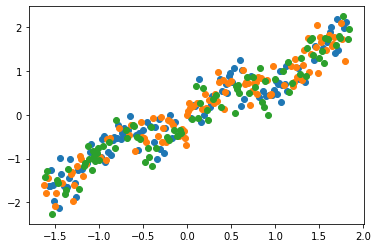

In [10]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);
plt.show()

In [11]:
# convert from nparray to Var
def nparray_to_Var(x):
    if x.ndim==1:
        y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
    else:
        y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
    return y
   
x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)


# Defining and initializing the network

The steps to create a feed forward neural network are the following:

1. **Number of hidden layer and hidden units**. We have to define the number of hidden units in each layer. The number of features in X and the output dimensionality (the size of Y) are given but the numbers in between are set by the researcher. Remember that for each unit in each layer beside in the input has a bias term.
2. **Activation functions** for each hidden layer. Each hidden layer in your list must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions that learn representations (features) from the data allowing us to learn from it. 
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of the exercise below. For now we will just use unit variance Gaussians.  

In order to make life easier for ourselves we define a DenseLayer class that takes care of initialization and the forward pass. We can also extend it later with print and advanced initialization capabilities. For the latter we have introduced a Initializer class.

Note that we use Sequence in the code below. A Sequence is an ordered list. This means the order we insert and access items are the same.

In [12]:
class Initializer:
    def init_weights(self, n_in, n_out):
        raise NotImplementedError

    def init_bias(self, n_out):
        raise NotImplementedError

In [13]:
import random

class NormalInitializer(Initializer):

    def __init__(self, mean=0, std=0.1):
        self.mean = mean
        self.std = std

    def init_weights(self, n_in, n_out):
        return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

    def init_bias(self, n_out):
        return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

    def __init__(self, weight=1.0, bias=0.0):
        self.weight = weight
        self.bias = bias

    def init_weights(self, n_in, n_out):
        return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

    def init_bias(self, n_out):
        return [Var(self.bias) for _ in range(n_out)]

In [14]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
        params = []
        for r in self.weights:
            params += r

        return params + self.bias

    def forward(self, inputs: Sequence[Var]) -> Sequence[Var]:
        assert len(self.weights) == len(inputs), "weights and inputs must match in first dimension"
        weights = self.weights
        out = []
        for j in range(len(weights[0])):
            node = self.bias[j] # <- Insert code
            for i in range(len(inputs)):
                node += inputs[i]*weights[0][j]  # <- Insert code
            node = self.act_fn(node)
            out.append(node)

        return out

## Exercise f) Complete the forward pass

In the code below we initialize a 1-5-1 network and pass the training set through it. The forward method in DenseLayer is not complete. It  just outputs zeros right now. The method forward should perform an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) on the input followed by an application of the activation function.

In [15]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):

    def forward_single(x, network):
        for layer in network:
            x = layer.forward(x)
        return x

    output = [ forward_single(input[n], network) for n in range(len(input))]
    return output

print(forward(x_train, NN))


[[Var(v=-0.0112, grad=0.0000)], [Var(v=-0.0225, grad=0.0000)], [Var(v=-0.0020, grad=0.0000)], [Var(v=-0.0339, grad=0.0000)], [Var(v=-0.0166, grad=0.0000)], [Var(v=-0.0153, grad=0.0000)], [Var(v=-0.0099, grad=0.0000)], [Var(v=-0.0081, grad=0.0000)], [Var(v=-0.0349, grad=0.0000)], [Var(v=-0.0062, grad=0.0000)], [Var(v=-0.0173, grad=0.0000)], [Var(v=-0.0215, grad=0.0000)], [Var(v=-0.0139, grad=0.0000)], [Var(v=-0.0246, grad=0.0000)], [Var(v=-0.0074, grad=0.0000)], [Var(v=-0.0144, grad=0.0000)], [Var(v=-0.0266, grad=0.0000)], [Var(v=-0.0126, grad=0.0000)], [Var(v=-0.0013, grad=0.0000)], [Var(v=-0.0044, grad=0.0000)], [Var(v=-0.0161, grad=0.0000)], [Var(v=-0.0071, grad=0.0000)], [Var(v=-0.0194, grad=0.0000)], [Var(v=-0.0196, grad=0.0000)], [Var(v=-0.0094, grad=0.0000)], [Var(v=-0.0254, grad=0.0000)], [Var(v=-0.0252, grad=0.0000)], [Var(v=-0.0277, grad=0.0000)], [Var(v=-0.0029, grad=0.0000)], [Var(v=-0.0175, grad=0.0000)], [Var(v=-0.0318, grad=0.0000)], [Var(v=-0.0042, grad=0.0000)], [Var(v=

## Exercise g) Print all network parameters

Make a function that prints all the parameters of the network (weights and biases) with information about in which layer the appear. In the object oriented spirit you should introduce a method in the DenseLayer class to print the parameters of a layer. Hint: You can take inspiration from the corresponding method in Var. 

In [16]:
## The repr function is defined again (already defined above):

def new_repr(self):
    return f'Weights: {repr(self.weights)} \nBiases: {repr(self.bias)}'

DenseLayer.__repr__ = new_repr

def show_layers(network):
    for i, n in enumerate(network):
        print(f'Layer {i+1}: \n{n} \n')
        
show_layers(NN)

Layer 1: 
Weights: [[Var(v=-0.0506, grad=0.0000), Var(v=-0.1067, grad=0.0000), Var(v=0.0344, grad=0.0000), Var(v=0.1172, grad=0.0000), Var(v=-0.0603, grad=0.0000)]] 
Biases: [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)] 

Layer 2: 
Weights: [[Var(v=-0.1023, grad=0.0000)], [Var(v=-0.0820, grad=0.0000)], [Var(v=-0.1325, grad=0.0000)], [Var(v=0.0016, grad=0.0000)], [Var(v=-0.0694, grad=0.0000)]] 
Biases: [Var(v=0.0000, grad=0.0000)] 



# Activation functions

To have a full definition of the neural network, we must define an activation function for every layer. Several activation functions have been proposed and have different characteristics. In the Var class we have already defined the rectified linear init (relu). 
 

## Exercise h) Add more activation functions

Implement the following activation functions in the Var class:

* Identity: $$\mathrm{identity}(x) = x$$
* Hyperbolic tangent: $$\tanh(x)$$
* Sigmoid (or logistic function): $$\mathrm{sigmoid}(x) = \frac{1}{1.0 + \exp(-x ) }$$  Hint: $\mathrm{sigmoid}'(x)= \mathrm{sigmoid}(x)(1-\mathrm{sigmoid}(x))$.  

Hint: You can seek inspiration in the relu method in the Var class.

## Visualization

Now that we have defined our activation functions we can visualize them to see what they look like:

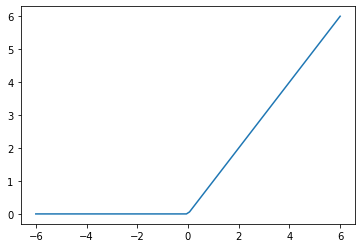

In [17]:
x = np.linspace(-6, 6, 100)

# convert from Var to ndarray  
def Var_to_nparray(x):
    y = np.zeros((len(x),len(x[0])))
    for i in range(len(x)):
        for j in range(len(x[0])):
            y[i,j] = x[i][j].v
    return y

# define 1-1 network with weight = 1 and relu activation 
NN = [ DenseLayer(1, 1, lambda x: x.relu(), initializer = ConstantInitializer(1.0)) ] 
y = Var_to_nparray(forward(nparray_to_Var(x), NN))

#y = Var_to_nparray(relu(nparray_to_Var(x)))
plt.plot(x,y)

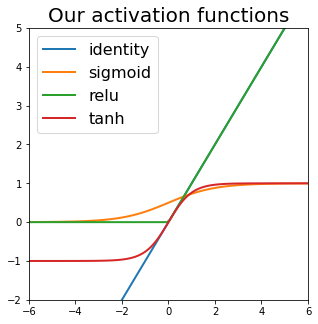

In [18]:
# Testing all activation layers

x = np.linspace(-6, 6, 100)
units = {
    "identity": lambda x: x.identity(),
    "sigmoid": lambda x: x.sigmoid(),
    "relu": lambda x: x.relu(),
    "tanh": lambda x: x.tanh()
}

plt.figure(figsize=(5, 5))
[plt.plot(x, Var_to_nparray(forward(nparray_to_Var(x), [DenseLayer(1, 1, unit, initializer = ConstantInitializer(1.0))]) ), label=unit_name, lw=2) for unit_name, unit in units.items()] # unit(nparray_to_Var(x))), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Our activation functions', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])
plt.show()

# Advanced initialization schemes

If we are not careful with initialization, the signals we propagate forward ($a^{(l)}$, $l=1,\ldots,L$) and backward ($\delta^l$, $l=L,L-1,\ldots,1$) can blow up or shrink to zero. A statistical analysis of the variance of the signals for different activation functions can be found in these two papers: [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf). 

The result of the analyses are proposals for how to make the initialization such that the variance of the signals (forward and backward) are kept approxmimatly constant when propagating from layer to layer. The exact expressions depend upon the non-linear activation function used. In Glorot initialization, the aim is to keep both the forward and backward variances constant whereas He only aims at keeping the variance in the forward pass constant.

We define $n_{in}$ and $n_{out}$ as the number of input units and output units of a particular layer. 

The Glorot initialization has the form: 

$$w_{ij} \sim N \bigg( 0, \, \frac{2 \alpha }{n_{in} + n_{out}} \bigg) \ . $$

where $N(\mu,\sigma^2)$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and $\alpha$ is a parameter that depends upon the activation function used. For $\tanh$, $\alpha=1$ and for Rectified Linear Unit (ReLU) activations, $\alpha=2$. (It is also possible to use a uniform distribution for initialization, see [this blog post](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init).) 

The He initialization is very similar

$$w_{ij} \sim N \bigg( 0, \, \frac{\alpha}{n_{in}} \bigg) \ . $$

## Exercise i) Glorot and He initialization
 
Using the Initializer class, implement functions that implement Glorot and He 

Explain briefly how you would test numerically that these initializations have the sought after property. Hint: See plots in Glorot paper.

Comment: If you want to be more advanced then try to make a universal initializer taking both the activation function and type (Glorot or He) as argument.

In [19]:
## Glorot
def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
    alpha = 1 # for tanh
    std = np.sqrt(2*alpha/(n_in+n_out)) # <- replace with proper initialization
    return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

## He
def DenseLayer_He_relu(n_in: int, n_out: int):
    alpha = 2
    std = np.sqrt(alpha/n_in) # <- replace with proper initialization
    return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

### Answer:

> To test if the initializatios have the desired property, it's possible to look at weights of the layers after each mini-batch, after it has done a foward and backward pass. Then, it's possible to find the standard deviations and the mean of the weights. These can then be plotted to see if they haven't changed too much from the distribution used.

## Exercise j) Forward pass unit test

Write a bit of code to make a unit test that the forward pass works. This can be done by defining a simple network with for example all weights equal to one (using the ConstantInitializer method) and identity activation functions. 

Hints: Use the [assert](https://www.w3schools.com/python/ref_keyword_assert.asp), the nparray_to_Var and the Var_to_nparray commands. 

In [20]:

simple_N = [DenseLayer(1, 1, lambda x: x.identity(), initializer=ConstantInitializer(1.0))]

inp = np.random.rand(3, 1)

def simple_test(inp, network):
    output = Var_to_nparray(forward(nparray_to_Var(inp), network))
    assert np.array_equal(inp, output)  # Checks if arrays are equal, for when more than one sample
    print(output)

simple_test(inp, simple_N)

[[0.37728416]
 [0.0200712 ]
 [0.32207917]]


# Loss functions

We are only missing a loss function to we need to define a loss function and its derivative with respect to the output of the neural network $y$

In [21]:
def squared_loss(t, y):
  
    # add check that sizes agree
  
    def squared_loss_single(t, y):
        Loss = Var(0.0)
        for i in range(len(t)): # sum over outputs
            Loss += (t[i]-y[i]) ** 2
        return Loss

    Loss = Var(0.0)
    for n in range(len(t)): # sum over training data
        Loss += squared_loss_single(t[n],y[n])
    return Loss

## Exercise j) Implement cross entropy loss

Insert code below to implement cross-entropy loss for general dimensionality of $t$. Use a logits formulation:
$$
\rm{Loss} = - \sum_i t_i \, log \, p_i 
$$
with $p$ given by the the softmax function in terms of the logits $h$:
$$
p_i = \frac{\exp(h_i)}{\sum_{i'} \exp(h_{i'} } .
$$
Inserting $p$ in the expression for the loss gives
$$
\rm{Loss} = - \sum_i t_i h_i + \rm{LogSumExp}(h) \ ,
$$
where 
$$
\rm{LogSumExp}(h) = \log \sum_i \exp h_i \ .
$$
This is true for $t$ being a one-hot vector. In practice you want to implement a [numerically stable](https://leimao.github.io/blog/LogSumExp/) version of LogSumExp. But we will not bother about that here.

Help: You can add these methods in the Var class:

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

In [22]:
def cross_entropy_loss(t, y):
     
    Loss = Var(0.0)

    logsumexp = lambda x: np.log(np.sum(np.exp(x)))
    for i in range(len(y)):
        Loss += logsumexp(y[i]) - np.sum(t[i]*y[i])
    
    return Loss

In [24]:
def cross_entropy_loss(t, y):    
        def ce_loss(t, y):
        a = Var(0.0)
        b = Var(0.0)
        for y_i in y:
            a -= t[i]*y[i]
            b += y_i.exp()
        
        return a + b.log()
    
    Loss = Var(0.0)
    for i in range(len(y)):
        Loss += ce_loss(t[i], y[i])
    
    return Loss

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 11)

# Backward pass

Now the magic happens! We get the calculation of the gradients for free. Just do:

In [ ]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train, output)
Loss.backward()

and the gradients will be calculated:

In [ ]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

# Backward pass unit test

Above we used finite differences to test that Nanograd is actually doing what it is supposed to do. We can in principle try the same for the neural network. But we will trust that the test above is enough.

# Training and validation

We are ready to train some neural networks!

We initialize again:

In [ ]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and make an update:

We introduce a help function parameters to have a handle in all parameters in the network.

In [ ]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

def parameters(network):
    params = []
    for layer in range(len(network)):
        params += network[layer].parameters()
    return params

def update_parameters(params, learning_rate=0.01):
    for p in params:
        p.v -= learning_rate*p.grad

def zero_gradients(params):
    for p in params:
        p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

In [ ]:
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

# Recommended hyper-parameters for 3-D: 
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients 
## of the activation functions.

In [ ]:
# Initialize training hyperparameters
EPOCHS = 200
LEARN_R = 2e-3 

In [ ]:
train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        


In [ ]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

# Testing

We have kept the calculation of the test error separate in order to emphasize that you should not use the test set in optimization.

In [ ]:
output_test = forward(x_test, NN)

In [ ]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

In [ ]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

## Exercise k) Show overfitting, underfitting and just right fitting

Vary the architecture and other things to show clear signs of overfitting (=training loss significantly lower than test loss) and underfitting (=not fitting enoung to training data so that test performance is also hurt).

See also if you can get a good compromise which leads to a low validation loss. 

For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two separate.

_Insert written answer here._

### Answer:

> Below we see that the test loss is:
> - Lower than both validation and training loss, for the overfitting example
> - Is very close to the validation loss for both the underfitting and just right example

> The validation set is used to give an evaluation of the models fit on the training data, and tune the hyperparameters. So, it's important to keep the validation and test set seperate, so you have the possibility to evaluate the model on fully "unseen" data and give an unbiased estimate of the generalization error.


First we create a function that creates a network, trains it and plot the train/validation loss, to minimize the amount of repeated code:

In [ ]:
def test_network(n_hidden: int=5, epochs: int=200, lr: float=2e-3):
    NN = [
        DenseLayer(1, n_hidden, lambda x: x.relu()),
        DenseLayer(n_hidden, 1, lambda x: x.identity())
    ]

    # Initialize training hyperparameters
    EPOCHS = epochs
    LEARN_R = lr

    train_loss = []
    val_loss = []

    for e in range(EPOCHS):

        # Forward pass and loss computation
        Loss = squared_loss(y_train, forward(x_train, NN))

        # Backward pass
        Loss.backward()

        # gradient descent update
        update_parameters(parameters(NN), LEARN_R)
        zero_gradients(parameters(NN))

        # Training loss
        train_loss.append(Loss.v)

        # Validation
        Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
        val_loss.append(Loss_validation.v)

        if e%10==0:
            print("{:4d}".format(e),
                  "({:5.2f}%)".format(e/EPOCHS*100), 
                  "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))

    plt.plot(range(len(train_loss)), train_loss, label='train')
    plt.plot(range(len(val_loss)), val_loss, label='val')
    plt.legend()
    plt.show()
        
    # Test set
    output_test = forward(x_test, NN)

    y_test_np = Var_to_nparray(y_test)
    plt.scatter(y_test_np, Var_to_nparray(output_test));
    plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
    plt.xlabel("y");
    plt.ylabel("$\hat{y}$");
    plt.title("Model prediction vs real in the test set, the close to the line the better")
    plt.grid(True);
    plt.axis('equal');
    plt.tight_layout();

    Loss_test = squared_loss(y_test, forward(x_test, NN))

    print("Test loss:  {:4.3f}".format(Loss_test.v))

### Overfitting

For overfitting we're using an architecture with 4 hidden units. The learning rate and amount of epochs stays the same as above. We see that the model overfit the training data as it has a much lower training loss than validation loss. We also see that the model also is past it's optimal performance. 

In [ ]:
test_network(n_hidden=4, epochs=200, lr=2e-3)

### Underfitting

Here we use the same architechture, but use a very low learning rate of $1^{-4}$ and 150 epochs. We see that the model barely reaches a minimum of loss and will therefore not perform optimally.

In [ ]:
test_network(n_hidden=4, epochs=150, lr=1e-4)

### Just right

Here we use an architecture with 5 hidden units, while for training we use 200 epochs and a learning rate of $1^{-3}$. This results in a model that seems to have reached a good "plateau" for the loss value. Here, the validation loss is even lower than the training loss. Though this model probably could get event better with a few more epochs.

In [ ]:
test_network(n_hidden=5, epochs=200, lr=1e-3)

# Next steps - classification

It is straight forward to extend what we have done to classification. 

For numerical stability it is better to make softmax and cross-entropy as one function so we write the cross entropy loss as a function of the logits we talked about last week. 

Next week we will see how to perform classification in PyTorch.

## Exercise l) optional - Implement backpropagation for classification

Should be possible with very few lines of code. :-)

In [ ]:
# Just add code.

## Exercise m) optional - Introduce a NeuralNetwork class

The functions we applied on the neural network (parameters, update_parameters and zero_gradients) can more naturally be included as methods in a NeuralNetwork class. Make such a class and modify the code to use it. 

In [ ]:
# just add some code